# Hand Gesture Recognition Project - DAT540 Introduction to Data Science
*Authors: Haakon Vollheim Webb, Håkon Nodeland, Magnus Kjellesvig Egeland, Ninh Bao Turong, William Vagle*


### Problem Statement
We are tasked with recognizing hand gestures. We want to use machine learning tools to build an effective and reliable model. This model, along with the webcam of the computer running the code, will be used to create a live feed of the models interpretations of the hand gestures. 

The code has the following structure:

0. Defining all Imports
1. Downloading the Dataset
2. Pre-Processing
3. Sanity Check
4. Defining a Model
5. Defining Hyper Parameters
6. Performing Cross Validation
7. Configuring Webcam Access
8. Predicting on a Single Frame
9. Live Feed of Predictions


In [6]:
# import libraries
import os
import zipfile

import cv2
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from keras_tuner import Hyperband

from pathlib import Path

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical


## 1. Downloading the Dataset
When running the code for the first time, we ensure that the user has the required dataset locally. If the dataset is not found locally, we download the it from kaggle and unzip it into /data/leapGestRecog.

In [7]:
# Define paths
dataset_folder = Path("./data/leapGestRecog").expanduser()  # Adjust folder name as needed
zip_path = Path("./data/archive.zip").expanduser()

if not dataset_folder.parent.exists():
    print(f"Creating the directory: {dataset_folder.parent}")
    dataset_folder.parent.mkdir(parents=True, exist_ok=True)

# Check if dataset folder exists
if not dataset_folder.exists():
    print("Dataset not found locally. Downloading...")
    
    if not zip_path.exists():
        # Run shell command to download the dataset if it doesn't exist
        !curl -L -o {zip_path} https://www.kaggle.com/api/v1/datasets/download/gti-upm/leapgestrecog
    
    # Unzip the downloaded file
    if zip_path.exists():
        print("Download complete. Extracting files...")
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(dataset_folder)  # Extracts to the folder above the zip file
        print("Extraction complete.")
    else:
        print("Download failed. Please check your connection or Kaggle API credentials.")
else:
    print("Dataset already exists locally.")


Creating the directory: data
Dataset not found locally. Downloading...


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

  0 2180M    0  204k    0     0   173k      0  3:34:03  0:00:01  3:34:02  173k
  0 2180M    0 19.6M    0     0  9091k      0  0:04:05  0:00:02  0:04:03 18.7M
  1 2180M    1 43.5M    0     0  13.6M      0  0:02:40  0:00:03  0:02:37 21.4M
  3 2180M    3 74.5M    0     0  17.8M      0  0:02:02  0:00:04  0:01:58 24.7M
  4 2180M    4  104M    0     0  20.1M      0  0:01:48  0:00:05  0:01:43 25.9M
  6 2180M    6  130M    0     0  21.0M      0  0:01:43  0:00:06  0:01:37 25.9M
  7 2180M    7  154M    0     0  21.4M      0  0:01:41  0:00:07  0:01:34 27.1M
  8 2180M    8  184M    0     0  22.6M      0  0:0

Download complete. Extracting files...
Extraction complete.


## 2. Pre-Processing
The pre-processing is split into 3 parts: Normalization, data augmentation and data preperation.

### Normalization
We need to ensure that all images are of the same size, and that they are in gray scale. We use the OpenCV python binary extention loader (cv2) to read the images in grayscale:

`img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)`

And we use it to resize the images to the desired dimentions, to ensure that all images are of the same size and shape:

`img_resized = cv2.resize(img, desired_size)`

The `images` and `labels` lists contains the images and labels in the uint8-encoded format. These will be used for the data augmentation.

In [8]:
# Initialize the list of images and labels
images = []
labels = []

# We only want to work with the first person's data (folder '00')
base_folder = './data/leapGestRecog/leapGestRecog/00/'

# Specify desired image size
desired_size = (128, 128)

if os.path.isdir(base_folder):
    # For each gesture folder
    for gesture_folder in os.listdir(base_folder):
        gesture_path = os.path.join(base_folder, gesture_folder)
        
        # Check if it's a directory
        if os.path.isdir(gesture_path):
            
            # Use gesture folder as label
            label = gesture_folder 
            
            # For each image in the gesture folder
            for filename in os.listdir(gesture_path):
                
                # Check if the file is an image
                if filename.endswith(".jpg") or filename.endswith(".png"):
                    
                    # Read the image in grayscale and resize
                    img_path = os.path.join(gesture_path, filename)
                    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                    
                    if img is not None:
                        img_resized = cv2.resize(img, desired_size)
                        
                        # Keep the image in uint8 format with pixel values in [0, 255]
                        images.append(img_resized)
                        labels.append(label)

### Data Augmentation
The dataset only contains 200 images of each hand gesture. We want to increase this by creating duplicates with slight augmentation. Using Tensorflow's ImageDataGenerator, we can specify how much we want to augment the images. It will rotate, shift, zoom, flip, and modify the brightness randomly for each image. For the implementation, it is specified that we want `augments_per_image` number of augments. These augmented images are then saved locally. 

In [9]:
# Convert images and labels to numpy arrays
images = np.array(images, dtype=np.uint8)
labels = np.array(labels)

# Reshape images to add channel dimension (grayscale images)
images = images.reshape((-1, desired_size[0], desired_size[1], 1))

# Augmentation settings
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True,
    shear_range=0.2,
    fill_mode='nearest'
)

# Create a directory to save augmented images
output_dir = 'data/augmented_images'
os.makedirs(output_dir, exist_ok=True)
for label in np.unique(labels):
    os.makedirs(f'{output_dir}/{label}', exist_ok=True)

# Augment and collect augmented images and labels
augmented_images = []
augmented_labels = []

# Number of augmentations per original image
augmentations_per_image = 2

# For each image
for idx in range(len(images)):
    img = images[idx]
    label = labels[idx]
    
    # Reshape to (1, height, width, channels) which is the expected shape for the flow() function
    img = img.reshape((1,) + img.shape)
    i = 0
    for batch in datagen.flow(
            img,
            batch_size=1,
            save_to_dir=output_dir+'/{}'.format(label),
            save_prefix=f'{idx}',
            save_format='jpeg'):
        
        # Append the augmented image and label to the lists
        augmented_images.append(batch[0])
        augmented_labels.append(label)
        i += 1
        if i >= augmentations_per_image:
            break

## Data Preperation
We want to combine the list of augmented images with the original samples. Additionally we need to add a channel dimenstion to the images, as it is a required field for Conv2D later on. Additionally we convert the labels to one-hot encoded vectors.

In [10]:
# Combine original and augmented data
all_images = np.concatenate((images, np.array(augmented_images, dtype=np.uint8)))
all_labels = np.concatenate((labels, np.array(augmented_labels)))

# Adding a channel dimension to the images. The images are grayscale so the channel dimension is 1.
# X here is a 4D array (number of samples, height, width, channels)
# which we can directly use in a Conv2D layer in the next code block
X = np.array(all_images).reshape(-1, desired_size[0], desired_size[1], 1)

#Convert labels to integers (i.e. convert '01_palm' to (for instance) 0)
le = LabelEncoder()
y = le.fit_transform(all_labels)

# Convert labels to one-hot encoded vectors
y_categorical = to_categorical(y)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.2, random_state=42)

## 3. Sanity Check
To ensure we our implementation are working so far, we want to display some sample images and the class distribution

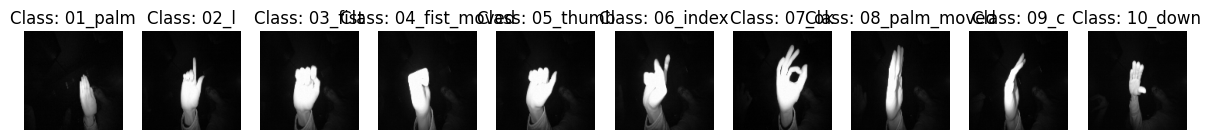

In [11]:
# Display sample images from each class
classes = np.unique(y)
fig, axes = plt.subplots(1, len(classes), figsize=(15, 5))
for i, cls in enumerate(classes):
    idx = y.tolist().index(cls)
    axes[i].imshow(all_images[idx], cmap='gray')
    axes[i].set_title(f"Class: {le.inverse_transform([cls])[0]}")
    axes[i].axis('off')
plt.show()


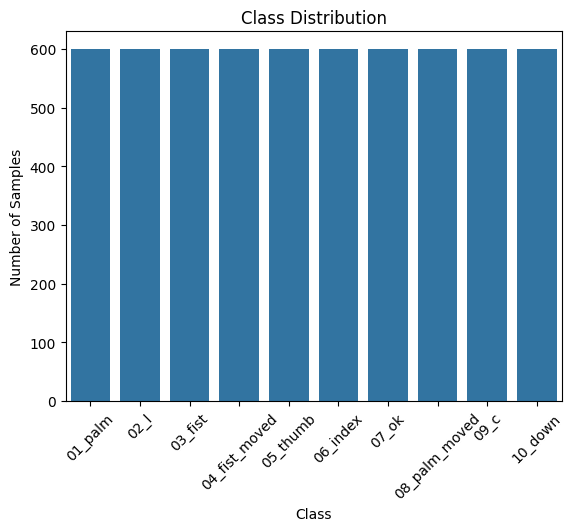

In [12]:
# Plot the distribution of classes, we can see that the classes are balanced
# as we have 200 * augments_per_image samples for each class, all classes have the same number of samples
sns.countplot(x=y)
plt.xlabel('Class')
plt.xticks(ticks=classes, labels=le.inverse_transform(classes), rotation=45)
plt.ylabel('Number of Samples')
plt.title('Class Distribution')
plt.show()

In [13]:
##########################
# Denne blokken kan vi sannsynligvis fjerne. Dette har blitt erstattet med hyperparameter 
# tuning-approachen.
##########################

# Build the CNN model
# The type of CNN we will use is a Sequential model which is
# a linear stack of layers. We will add convolutional, pooling,
# and dense layers to this model.
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(desired_size[0], desired_size[1], 1)),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(len(classes), activation='softmax')
])
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

c:\Users\haako\OneDrive\UiS\DAT540\dat-540-project\myenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [14]:
#########################
# Denne blokken kan vi sannsynligvis fjerne. Dette har blitt erstattet med hyperparameter 
# tuning-approachen.
#########################

# Fit the model with validation
# history here is a history object that contains the loss and accuracy values during training
# which we can use to plot the training and validation loss and accuracy

#Hyper parameters
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1)

# See below how the loss improves and the accuracy increases (by a lot) over time
# This means that the training is working and the model is learning from the data


Epoch 1/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 13s 85ms/step - accuracy: 0.4365 - loss: 27.6810 - val_accuracy: 0.7583 - val_loss: 0.8199
Epoch 2/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 11s 78ms/step - accuracy: 0.9091 - loss: 0.2819 - val_accuracy: 0.8354 - val_loss: 0.5734
Epoch 3/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 11s 79ms/step - accuracy: 0.9787 - loss: 0.0673 - val_accuracy: 0.8604 - val_loss: 0.5371
Epoch 4/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - accuracy: 0.9928 - loss: 0.0250 - val_accuracy: 0.8542 - val_loss: 0.7337
Epoch 5/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 11s 78ms/step - accuracy: 0.9960 - loss: 0.0200 - val_accuracy: 0.8687 - val_loss: 0.6959
Epoch 6/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 10s 76ms/step - accuracy: 0.9972 - loss: 0.0094 - val_accuracy: 0.8104 - val_loss: 0.9458
Epoch 7/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - accuracy: 0.9902 - loss: 0.0387 - val_accuracy: 0.7979 - val_loss: 1.2645
Epoch 8/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - accuracy: 0.9726 - loss: 0.0956 -

## 4. Building the model

We are using a sequential model, which allows for a linear stack of layers. We are building a CNN, where 

The first layer is responsible for extracting basic features from the input image, reducing its spatial size, and preparing the data for deeper layers to learn higher-level features.

The second layer is responsible for refining and combining the features extracted by the first layer to build a more abstract and detailed representation of the input data.

The third layer, the flatten and dense layer, helps the network transition from feature extraction to learning the relationships necessary for classification.

Finally we have the output layer which is responsible of producing the final classification output.


All of the parameters defined in the `build_model(hp)` function are tunable. This is because we are using this function to perform the hyperparameter tuning.

In [15]:
def build_model(hp):
    # Create a Sequential model. A sequential model is a linear stack of layers.
    # It is a type of CNN model that is suitable for a plain stack of layers where each layer has exactly one input tensor and one output tensor.
    model = Sequential()
    
    
    # First Convolutional Layer with tunable number of filters and kernel size
    model.add(Conv2D(
        filters=hp.Int('conv_1_filters', min_value=32, max_value=128, step=32),
        kernel_size=hp.Choice('conv_1_kernel', values=[3, 5]),
        activation='relu',
        input_shape=(desired_size[0], desired_size[1], 1)
    ))
    model.add(MaxPooling2D((2, 2)))
    
    # Second Convolutional Layer with tunable number of filters and kernel size
    model.add(Conv2D(
        filters=hp.Int('conv_2_filters', min_value=64, max_value=256, step=32),
        kernel_size=hp.Choice('conv_2_kernel', values=[3, 5]),
        activation='relu'
    ))
    model.add(MaxPooling2D((2, 2)))
    
    # Flatten and Dense Layers with tunable dense units and dropout rate
    model.add(Flatten())
    model.add(Dense(units=hp.Int('dense_units', min_value=64, max_value=256, step=32), activation='relu'))
    model.add(Dropout(rate=hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1)))
    
    # Output Layer
    model.add(Dense(len(classes), activation='softmax'))
    
    # Compile model with tunable learning rate
    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('learning_rate', values=[1e-3, 1e-4, 1e-5])),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# 5. Defining Hyper Parameters
To find the hyper parameters, we use keras' Hyperband class. This class has the search() method, which performs a search for the best hyper parameters. This search is only required to be performed once. We can later use the found parameters to define a single model. Additionally, we will use these parameters for constructing the models during the Cross-Validation.

In [16]:
# Define the tuner and its parameters
tuner = Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=20,
    factor=3,
    directory='tuning_dir',
    project_name='hand_sign_tuning'
)

In [17]:
# Run the tuner search.
# ETA: 2.5 hours, depending on the cpu/gpu, augments_per_image, max_epochs and factor.
# Only necessary if you want to run the search again.

tuner.search(X_train, y_train, epochs=20, validation_split=0.1, batch_size=32)

Trial 30 Complete [00h 05m 30s]
val_accuracy: 0.9020833373069763

Best val_accuracy So Far: 0.9395833611488342
Total elapsed time: 02h 30m 06s


In [18]:
# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Display the best hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters(1)[0]
print("Best Hyperparameters:")
print(f"Conv Layer 1 Filters: {best_hyperparameters.get('conv_1_filters')}")
print(f"Conv Layer 1 Kernel Size: {best_hyperparameters.get('conv_1_kernel')}")
print(f"Conv Layer 2 Filters: {best_hyperparameters.get('conv_2_filters')}")
print(f"Conv Layer 2 Kernel Size: {best_hyperparameters.get('conv_2_kernel')}")
print(f"Dense Units: {best_hyperparameters.get('dense_units')}")
print(f"Dropout Rate: {best_hyperparameters.get('dropout')}")
print(f"Learning Rate: {best_hyperparameters.get('learning_rate')}")


# # Evaluate the model on the test set
test_loss, test_accuracy = best_model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

Best Hyperparameters:
Conv Layer 1 Filters: 32
Conv Layer 1 Kernel Size: 5
Conv Layer 2 Filters: 128
Conv Layer 2 Kernel Size: 5
Dense Units: 256
Dropout Rate: 0.2
Learning Rate: 0.0001
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.9333 - loss: 0.3256
Test Accuracy: 0.9275


## 6. Cross Validation

To ensure that we have a good model, we want to cross validate it. This ensures us that the model reads unseed data in a good manner, that it is not over-fitted while also being a good process for evaluating the performance of the model. We are using the hyper parameters found in step 5.

In [19]:
# Ensure y is in integer format (not one-hot encoded)
# If y is one-hot encoded, convert it back to integer labels
if y.ndim > 1:
    y_labels = np.argmax(y, axis=1)
else:
    y_labels = y
    
#
def build_model_with_parameters():

    # Best Hyperparameters:
    # Conv Layer 1 Filters: 128
    # Conv Layer 1 Kernel Size: 3
    # Conv Layer 2 Filters: 96
    # Conv Layer 2 Kernel Size: 5
    # Dense Units: 192
    # Dropout Rate: 0.30000000000000004
    # Learning Rate: 1e-05

    # WEBB:
    #Best Hyperparameters:
    # Conv Layer 1 Filters: 32
    # Conv Layer 1 Kernel Size: 5
    # Conv Layer 2 Filters: 128
    # Conv Layer 2 Kernel Size: 5
    # Dense Units: 256
    # Dropout Rate: 0.2
    # Learning Rate: 0.0001
    # 38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.9333 - loss: 0.3256
    # Test Accuracy: 0.9275

    # Best Hyperparameters
    conv_1_filters = 128
    conv_1_kernel = 3
    conv_2_filters = 96
    conv_2_kernel = 5
    dense_units = 192
    dropout_rate = 0.3
    learning_rate = 0.00001

    

    # Build the model
    model = Sequential()
    model.add(Conv2D(filters=conv_1_filters,
                     kernel_size=(conv_1_kernel, conv_1_kernel),
                     activation='relu',
                     input_shape=(desired_size[0], desired_size[1], 1)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=conv_2_filters,
                     kernel_size=(conv_2_kernel, conv_2_kernel),
                     activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(units=dense_units, activation='relu'))
    model.add(Dropout(rate=dropout_rate))
    model.add(Dense(len(classes), activation='softmax'))

    # Compile the model
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model



# Define the number of folds
n_splits = 5

# Initialize StratifiedKFold
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

fold_no = 1
accuracy_per_fold = []
loss_per_fold = []

for train_index, val_index in skf.split(X, y_labels):
    print(f'Fold {fold_no} -------------------------------------')

    # Split data
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    # Ensure labels are one-hot encoded
    y_train_categorical = to_categorical(y_train, num_classes=len(classes))
    y_val_categorical = to_categorical(y_val, num_classes=len(classes))

    # Build a fresh model for each fold
    model = build_model_with_parameters()

    # Train the model
    history = model.fit(X_train, y_train_categorical,
                        epochs=20,
                        batch_size=32,
                        validation_data=(X_val, y_val_categorical),
                        verbose=1)

    # Evaluate the model
    scores = model.evaluate(X_val, y_val_categorical, verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} = {scores[0]:.4f}; {model.metrics_names[1]} = {scores[1]:.4f}')
    accuracy_per_fold.append(scores[1])
    loss_per_fold.append(scores[0])

    fold_no += 1


print('-------------------------------------')
print('Score per fold')
for i in range(len(accuracy_per_fold)):
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]:.4f} - Accuracy: {accuracy_per_fold[i]:.4f}%')
print('-------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(accuracy_per_fold):.4f} (+- {np.std(accuracy_per_fold):.4f})')
print(f'> Loss: {np.mean(loss_per_fold):.4f}')
print('-------------------------------------')


# Score per fold
# > Fold 1 - Loss: 0.0039 - Accuracy: 1.0000%
# > Fold 2 - Loss: 0.0066 - Accuracy: 1.0000%
# > Fold 3 - Loss: 0.0054 - Accuracy: 1.0000%
# > Fold 4 - Loss: 0.0044 - Accuracy: 1.0000%
# > Fold 5 - Loss: 0.0051 - Accuracy: 1.0000%
# -------------------------------------
# Average scores for all folds:
# > Accuracy: 1.0000 (+- 0.0000)
# > Loss: 0.0051


Fold 1 -------------------------------------
Epoch 1/20


c:\Users\haako\OneDrive\UiS\DAT540\dat-540-project\myenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


150/150 ━━━━━━━━━━━━━━━━━━━━ 56s 372ms/step - accuracy: 0.2908 - loss: 4.9541 - val_accuracy: 0.5442 - val_loss: 1.3490
Epoch 2/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 56s 372ms/step - accuracy: 0.5701 - loss: 1.2858 - val_accuracy: 0.6192 - val_loss: 1.0568
Epoch 3/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.6755 - loss: 0.9124 - val_accuracy: 0.7050 - val_loss: 0.8659
Epoch 4/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 56s 374ms/step - accuracy: 0.7563 - loss: 0.7329 - val_accuracy: 0.7467 - val_loss: 0.7562
Epoch 5/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 56s 375ms/step - accuracy: 0.7934 - loss: 0.5686 - val_accuracy: 0.8058 - val_loss: 0.5967
Epoch 6/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 56s 372ms/step - accuracy: 0.8499 - loss: 0.4435 - val_accuracy: 0.8158 - val_loss: 0.5531
Epoch 7/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 56s 375ms/step - accuracy: 0.8939 - loss: 0.3219 - val_accuracy: 0.8358 - val_loss: 0.4780
Epoch 8/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 55s 370ms/step - accuracy: 0.9095 - loss: 0.2711 - val

In [20]:


# Make predictions on the test set
y_pred = best_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)


# Convert one-hot encoded y_test back to labels
y_test_classes = np.argmax(y_test, axis=1)

# Accuracy
accuracy = accuracy_score(y_test_classes, y_pred_classes)
print(f"Test Accuracy: {accuracy:.2f}")

# Classification Report
print("Classification Report:")
print(classification_report(y_test_classes, y_pred_classes, target_names=le.classes_))


38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step
Test Accuracy: 0.93
Classification Report:
               precision    recall  f1-score   support

      01_palm       0.91      0.98      0.94       125
         02_l       0.97      0.89      0.93       108
      03_fist       0.88      0.91      0.90       133
04_fist_moved       0.94      0.95      0.94       106
     05_thumb       0.96      0.80      0.88       123
     06_index       0.86      0.93      0.90       120
        07_ok       0.94      0.97      0.96       124
08_palm_moved       0.95      0.93      0.94       123
         09_c       0.95      0.98      0.96       122
      10_down       0.93      0.93      0.93       116

     accuracy                           0.93      1200
    macro avg       0.93      0.93      0.93      1200
 weighted avg       0.93      0.93      0.93      1200



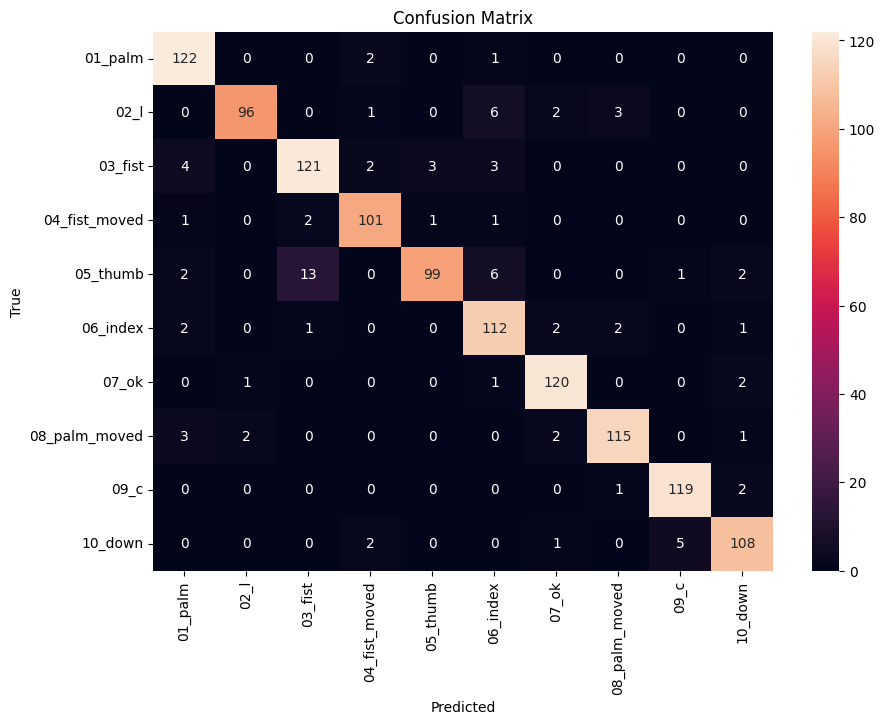

In [21]:


cm = confusion_matrix(y_test_classes, y_pred_classes)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

#Shows actual (y-axis) vs predicted values (x-axis)
#The diagonal represents the correct predictions
#The diagonal shows that the model never predicts false positives



In [22]:
#Save the model
best_model.save('gesture_recognition_model.keras')

In [23]:
#TODO: Cross validation
# Cross validation is a technique used to evaluate the performance of a model
# on a limited data sample. It is used to estimate how the model will perform
# in a general setting. The idea is to split the data into multiple folds
# and train the model on all but one fold and test on the remaining fold.

# This can be implemented using the KFold class from scikit-learn.

In [24]:
#TODO: Data augmentation
# Data augmentation is a technique to artificially create new training data from existing training data.
# This is done by applying random (but realistic) transformations to the existing data.
# For example, you can rotate, flip, zoom in, or change the brightness of an image.
# This can help the model generalize better to new, unseen data.
# Keras provides a built-in ImageDataGenerator class that can be used for data augmentation.





In [25]:
# If our use case is to be able to recognize gestures in real-time, then a step we need to take is to  
# access the webcam and use the model to make predictions on the video stream.

# TODO: Acess the webcam
# To access the webcam, we can use the OpenCV library which provides
# a VideoCapture class to capture video from the webcam.

In [26]:
#TODO: Make predictions on the video stream from the webcam
# This is something we can use in our presentation of the project
